In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import am_sim as ams

In [2]:
from utilities.analyze_inference import best_par_in_df

# load inferred parameter set
search_df = pd.read_csv('inference_results/t_final_search_history.csv', index_col=0)
par = best_par_in_df(search_df)

In [3]:
from utilities.simulate_stoch_GC_evo import initialize_GC_with_stoch_pop, evolve_GC_till_extinction

# set random seed for reproducibility
np.random.seed(21)

# high and low Ag dosages
D_low = 1.
D_high = 10.

# extract initial population, the same for the two simulations
init_st_pop = ams.stoch_pop(par)

# Create two GCs with the same initial population
GC_low = initialize_GC_with_stoch_pop(D_inj=D_low, par=par, st_pop=init_st_pop)
GC_high = initialize_GC_with_stoch_pop(D_inj=D_high, par=par,st_pop=init_st_pop)

# evolve the GCs, returns dictionary of results.
# The dictiornary containts info on the final MC/PC population,
# population evolution and Ag evolution.
# See the function definition for more info on the form of the dicionary.
res_low = evolve_GC_till_extinction(par=par, GC=GC_low)
res_high = evolve_GC_till_extinction(par=par, GC=GC_high)

### Panel B

In [4]:
# define global parameters of the plots

# weeks at which to plot the population distribution
plot_weeks = [1,2,4,8,12]
# plot x-limits, will be the same for panel B and D
xlims = [-24,-10]
# binning of the histograms, will be the same for panel B and D
bins = np.linspace(xlims[0]-20, xlims[1]+20,150)
# colors for the two distributions (low and high dosages respectively)
colors = ['C0', 'C1']

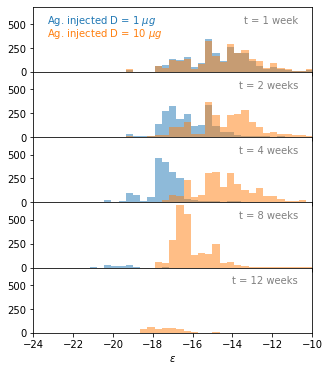

In [5]:
# function to extract the population corresponding to a specific day from the dictionary of results
def select_pop_from_day(res, day):
    pop_en = res['GC_pop_en']
    time = res['GC_t']
    time_idxs = np.argwhere(time == day).flatten()
    if time_idxs.size > 0:
        time_idx = time_idxs[0]
        return pop_en[time_idx]
    else:
        return None

# initialze figure
fig, ax = plt.subplots(len(plot_weeks),1, sharex=True, sharey=True, figsize=(5,6))

# for the high and low dosage cases
for n_res, res in enumerate([res_low, res_high]):
    # and for every week
    for nw, w  in enumerate(plot_weeks):
        # extract list of binding energy of the population at the specified time
        pop_en = select_pop_from_day(res, day=w*7.)
        if pop_en is not None:
            # if the population is alive at this time then plot the histogram
            ax[nw].hist(pop_en, bins=bins, color=colors[n_res], alpha=0.5)
            
# for every plot subplot specify the time:
for nw, w  in enumerate(plot_weeks):
    ax[nw].text(0.95, 0.75,f't = {w} week' + 's'*(w>1), transform=ax[nw].transAxes,
                color='gray', horizontalalignment='right')

# add injected dosages for the two cases
ax[0].text(0.05, 0.75,f'Ag. injected D = {int(D_low)} ' + r'$\mu g$', transform=ax[0].transAxes, color=colors[0])
ax[0].text(0.05, 0.55,f'Ag. injected D = {int(D_high)} ' + r'$\mu g$', transform=ax[0].transAxes, color=colors[1])

# figure and axes adjustments
ax[-1].set_xlabel(r'$\epsilon$')
plt.xlim(xlims)
plt.subplots_adjust(hspace=0)

# save and show figure
plt.savefig('figures/fig_2/pop_hist.pdf')
plt.savefig('figures/fig_2/pop_hist.svg')
plt.show()

### Panel C

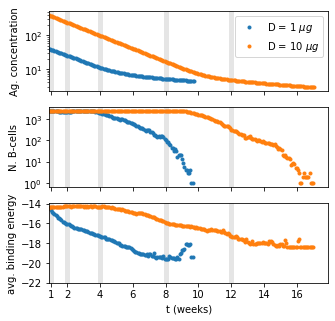

In [7]:
# setup figure
fig, ax = plt.subplots(3,1, sharex=True, figsize=(5,5))

# mark with vertical gray lines the time-points at which the histogram is plotted in panel B
for nw, w in enumerate(plot_weeks):
    for a in ax:
        a.axvline(w, c='grey', ls='-', linewidth=5, alpha=0.2)

D_list = [D_low, D_high]
# for both the high and low dosage cases
for nr, res in enumerate([res_low, res_high]):
    # extract quantitities to plot from the result dictionary
    t, N, avg_eps = [res[lab] for lab in ['GC_t', 'GC_N', 'GC_avg_eps']]
    ag_t, ag_C = [res[lab] for lab in ['ag_t', 'ag_C']]
    
    # plot Ag evolution
    ax[0].plot(ag_t / 7., ag_C, '.',label=f'D = {int(D_list[nr])} ' + r'$\mu g$', c=colors[nr])

    # plot number of cells
    ax[1].plot(t / 7, N, '.', c=colors[nr])

    # plot average energy
    ax[2].plot(t/7, avg_eps, '.', c=colors[nr])

# set labels, limits and scale axis 0
ax[0].set_ylabel('Ag. concentration')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_xlim(left=0.9)

# set labels, limits and scale axis 1
ax[1].set_yscale('log')
ax[1].set_ylabel('N. B-cells')
ax[1].set_yticks([1,10,100,1000])

# set labels, limits and scale axis 2
ax[2].set_ylabel(r'avg. binding energy')
ax[2].set_xlabel('t (weeks)')    
ax[2].set_yticks([-22, -20,-18,-16, -14])
ax[2].set_xticks(np.append([1], np.arange(2,18,2)))

# save and show figure
plt.savefig('figures/fig_2/pop_evo.pdf')
plt.savefig('figures/fig_2/pop_evo.svg')
plt.show()
    

### Panel D

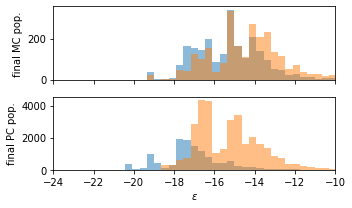

In [8]:
# setup figure
fig, ax = plt.subplots(2,1, sharex=True, sharey=False, figsize=(5,3))

# for the high and low dosage cases
for n_res, res in enumerate([res_low, res_high]):
    # plot MC binding energy histogram
    MC_en = res['MC_en']
    ax[0].hist(MC_en, color=colors[n_res], alpha=0.5, bins=bins)
    # plot PC binding energy histogram
    PC_en = res['PC_en']
    ax[1].hist(PC_en, color=colors[n_res], alpha=0.5, bins=bins)

# figure and axes adjustements
ax[0].set_ylabel('final MC pop.')
ax[1].set_ylabel('final PC pop.')
ax[-1].set_xlabel(r'$\epsilon$')
plt.xlim(xlims)
plt.ylim(bottom=0)

# save and show figure
plt.tight_layout()
plt.savefig('figures/fig_2/MC_PC_hist.pdf')
plt.savefig('figures/fig_2/MC_PC_hist.svg')
plt.show()